# Разметка
Для разметки автомобильных номеров в проекте толоки мы использовали 3 класса:
- yes - гражданский российский номер современного образца
- no - номер транспортного средства, который не соотвествует yes
- other - не является фотографией номера транспортного средства

В инструкции мы расписали все крайние случаи, которые нашли в размеченном датасете. Например, у тракторных номеров может не быть надписи RUS и флага, а российские номера с черным фоном не являются гражданскими.  Так как мы ориентировались на русскоязычных толокеров, то инструкция была соответственно на русском. 

Для начала мы решили разметить 2000 картинок, чтобы обучить на них бейзалйн и, применив к остальным 6500, выбрать 3700 картинок с наименьшим confidence, чтобы дообучить модель. 

В обоих пулах мы использовали обучение толокеров, где собрали 10 вопросов, покрывающих большинство возможных вариантов, и одинаковый контроль качества. 

Контроль качества в нашем проекте включает:
- Допуск толокеров, которые ответили правильно как минимум на 6 из 10 вопросов обучения.
- Бан тех, кто 5 раз подярд сдал задание быстрее, чем за 7 секунд.
- Допуск по скиллу классификации номеров, который мы сами вычисляем как процент правильных ответов на последних 10 контрольных заданяих (но не менее 4-ех). На каждой странице с заданием случайно вмешивается одно контрольное задание.

# Обучение
В качестве модели классификации мы выбрали MobileNetV2, предобученный на ImageNet.

Бейслайн обучался на 2000 размеченных изображениях в конфигурации 
- 10 эпох
- AdamW
- lr=1e-4
- batch_size=64
- ресайз к размеру (3, 100, 100)
- нормализация на среднее (0.5, 0.5, 0.5) и дисперсию (0.5, 0.5, 0.5)

Он достиг `f1-score = 0.88` на трейне. Наиболее неуверенные 3700 кейсов были отправлены на разметку.

В произвольном порядке были перебраны некоторые параметры выше. Лучшая модель обучалась на 5900 размеченных изображениях в конфигурации
- 16 эпох
- Adam
- lr=1e-3
- batch_size=64
- паддинг & кроп к размеру (3, 224, 224)
- вес 6 на таргет класс российских номеров
- нормализация на среднее и дисперсию ImageNet
- FP16

Лучшая модель достигла `f1-score = 1` на трейне и `f1-score = 0.99` на публичном тесте

In [ ]:
%load_ext autoreload
%autoreload 2

In [43]:
!wget https://tlk.s3.yandex.net/course/shad_cv_project_22/dataset_students.zip
!unzip dataset_students.zip
!pip install -q pytorch-lightning wandb
!pip install ipyplot
!pip install timm
!git clone https://github.com/alekseyen/TolokaCvProject.git
!mv TolokaCvProject/* .

Cloning into 'TolokaCvProject'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 89 (delta 42), reused 82 (delta 35), pack-reused 0
Unpacking objects: 100% (89/89), done.


In [ ]:
import pandas as pd
import ipyplot
import torch
import pytorch_lightning as pl
from sklearn.metrics import f1_score
%matplotlib inline

In [45]:
from src.model import ImageClassifier
from src.utils import ImagesDataset, evaluate_model
from src.transforms import transform
from src import params

In [ ]:
!nvidia-smi

Wed Oct 12 14:51:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load dataset

In [46]:
annotated0_df = pd.read_csv('train_labelled.tsv', sep='\t', index_col=None)
annotated0_df['OUTPUT:result'] = annotated0_df['GOLDEN:result']
annotated0_df = annotated0_df.drop('GOLDEN:result', axis=1)
annotated1_df = pd.read_csv('aggregated_results_by_ds__pool_35739415__2022_10_05.tsv', sep='\t', index_col=None)
annotated2_df = pd.read_csv('aggregated_results_by_ds__pool_35803045__2022_10_09.tsv', sep='\t', index_col=None)

train_df = pd.concat([annotated0_df, annotated1_df, annotated2_df]).drop('Unnamed: 3', axis=1)
train_df['INPUT:image'] = 'dataset_students/classification/train_' + train_df['INPUT:image']
train_df = train_df.fillna('100.00%').drop_duplicates()
train_df.head()

,INPUT:image,OUTPUT:result,CONFIDENCE:result
0,dataset_students/classification/train_labelled...,no,100.00%
1,dataset_students/classification/train_labelled...,other,100.00%
2,dataset_students/classification/train_labelled...,no,100.00%
3,dataset_students/classification/train_labelled...,no,100.00%
4,dataset_students/classification/train_labelled...,no,100.00%


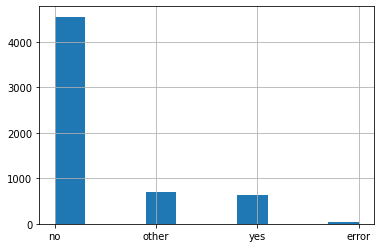

In [47]:
train_df['OUTPUT:result'].hist()

In [48]:
train_df['OUTPUT:result'] = train_df['OUTPUT:result'].map(dict(yes=1, no=0, other=2, error=2)).astype(int)

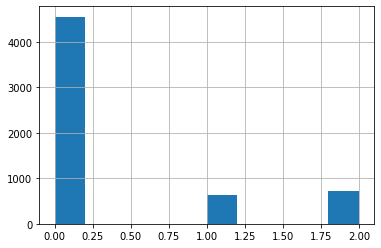

In [49]:
train_df['OUTPUT:result'].hist()

In [50]:
train_image_paths = train_df['INPUT:image'].values
train_labels = train_df['OUTPUT:result'].values

In [51]:
print(f'{len(train_image_paths)} train images')

5900 train images


In [ ]:
ipyplot.plot_class_tabs(train_image_paths, train_labels, max_imgs_per_tab = 10)

# Prepare model

In [53]:
!pip install imops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
train_dataset = ImagesDataset(train_image_paths, train_labels, transform=transform)

## To preserve original image scales we padded & cropped all images to (3, 224, 224)

In [55]:
from imops import pad_to_shape, crop_to_shape
import numpy as np

def collate_batch(batch, dtype):
  label_list, images_list, shapes_list = [], [], []

  for (img, label, _) in batch:
    label_list.append(label)
    images_list.append(img)
    shapes_list.append(torch.tensor(img.shape))
   
  label_list = torch.tensor(label_list, dtype=torch.int64)
  max_shape = torch.stack(shapes_list).amax(axis=0)

  final_images = []
  for img in images_list:
    final_images.append(torch.tensor(crop_to_shape(pad_to_shape(img, np.maximum(max_shape.numpy(), (3, 224, 224))), (224, 224), axis=(-1, -2))))
  
  return torch.stack(final_images).to(dtype), label_list, None


In [56]:
from functools import partial
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           collate_fn=partial(collate_batch, dtype=torch.float16),
                                           batch_size=params.BATCH_SIZE,
                                           num_workers=2,
                                           shuffle=False)

## To adress class imbalance we applied weight = 6 to the target class (russian car numbers)

In [57]:
# Run macos_cert_fix.py if you are getting ssl errors
import torch
model = ImageClassifier(learning_rate=params.LEARNING_RATE, class_weight=torch.tensor([1.0, 6.0, 1.0], device='cuda'))

In [58]:
from pytorch_lightning import Trainer, seed_everything

seed_everything(1337, workers=True)

trainer = pl.Trainer(
    #logger=logger,
    max_epochs=params.MAX_EPOCHS,
    log_every_n_steps=1, # Change to enable tensorboard logging
    gpus=1, # Uncomment to use GPU training
    precision=16,
)
trainer.fit(model, train_loader)

INFO:pytorch_lightning.utilities.seed:Global seed set to 1337
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:109: PossibleUserWarning: You defined a `validation_step` but have no `val_d

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=16` reached.


# Compute training set f1-score

In [59]:
labels, predictions = evaluate_model(model, train_dataset, collate_fn=partial(collate_batch, dtype=torch.float32))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/185 [00:00<?, ?it/s]

In [60]:
predictions = [0 if x == 2 else x for x in predictions ]
labels = [0 if x == 2 else x for x in labels ]

In [61]:
f1_score(labels, predictions, labels=1, average='binary')

0.9992019154030327

## Evaluate on val


In [ ]:
!wget https://tlk.s3.yandex.net/course/shad_cv_project_22/val.zip
!unzip val.zip

In [ ]:
import os

full_image_paths = []

dataset_dir = 'val'

for file in os.listdir(dataset_dir):
    if file.endswith(".png"):
        full_image_paths += [os.path.join(dataset_dir, file)]


len(full_image_paths)

In [ ]:
other_part_dataset = ImagesDataset(full_image_paths, transform=transform)

labels, predictions = evaluate_model(model, other_part_dataset, collate_fn=partial(collate_batch, dtype=torch.float32))

In [ ]:
full_image_paths = [x.split('/')[-1] for x in full_image_paths]

In [ ]:
predictions = [int(x == 1) for x in predictions]

In [ ]:
df = pd.DataFrame(dict(img_path=full_image_paths, label = predictions))

df.head(10)

In [ ]:
df['label'].hist()

In [ ]:
df.to_csv('results.csv', index=False, sep=',')

In [ ]:
trainer.save_checkpoint("model.ckpt")